# modeling multivariate with nn model

前面我們建立過了baseline, 單變量時間序列模型, 接下來要做的是把nn model的實力發揚光大  
本節將要進行多變數的時間序列預測，透過我們前一節所做的特徵篩選來強化模型  
看能否有機會更進一步提升解釋能力  

在我們前面所選擇的模型中，只有TSMixerx, MLP, MLPMultivariate支援多變數  
因此接下來只會引用這三種模型框架結合變數進行建模

# Lib

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import time
import sys

# 將 hwttp 資料夾加入 Python 搜尋路徑
sys.path.append(os.path.abspath('..'))
import hwttp.hwtoolkit as tk

# neuralnetwork methods
from neuralforecast import NeuralForecast
from neuralforecast.models import (
    TSMixerx,
    MLPMultivariate,
)

# evaluate
from utilsforecast.losses import mse, mae, rmse, smape
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, MAE, RMSE # modeling use
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series


# extra
import importlib

# 必要
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
from pathlib import Path

# Load data

## all features

In [4]:
parquet_path = "../data/features/all_features_by_intergrantry/"

p = Path(parquet_path)
all_feature_dfs = dict()

for f in p.glob("*.parquet"):
    all_feature_dfs[f.name.replace('_b_p_c_h_t_r.parquet', '')] = pd.read_parquet(f)

In [5]:
all_feature_dfs['05F0528N-05F0438N'].keys()

Index(['gf_gt', 'GantryFrom', 'GantryTo', 'TimeStamp', 'WeightedAvgTravelTime',
       'TotalTraffic', 'ds_prev_1_WATT', 'ds_prev_2_WATT', 'ds_prev_3_WATT',
       'ds_prev_4_WATT', 'ds_prev_5_WATT', 'congestion_syndrome',
       'holiday_continue', 'holiday_length', 'dayofweek', 'holiday_name_七夕情人節',
       'holiday_name_中元節', 'holiday_name_中秋節', 'holiday_name_二二八紀念日',
       'holiday_name_元宵節', 'holiday_name_兒童與清明節', 'holiday_name_勞動節',
       'holiday_name_國慶日', 'holiday_name_教師節', 'holiday_name_母親節',
       'holiday_name_父親節', 'holiday_name_白色情人節', 'holiday_name_端午節',
       'holiday_name_聖誕節', 'holiday_name_萬聖節', 'holiday_name_西洋情人節',
       'holiday_name_跨年元旦', 'holiday_name_農曆新年', 'accident_mileage',
       'event_occurrence', 'event_exclusion', 'handling_minutes',
       'accident_type', 'death_count', 'injuries_count', 'inner_shoulder_flag',
       'inner_lane_flag', 'middle_inner_lane_flag', 'middle_lane_flag',
       'middle_outer_lane_flag', 'outer_lane_flag', 'outer_should

## selected feature

In [6]:
parquet_path = "../data/features/feature_selection_results/"

p = Path(parquet_path)
fs_results = dict()

for f in p.glob("*.csv"):
    fs_results[f.name.replace('_b_p_c_h_t_r.csv', '')] = pd.read_csv(f)

# Preprocessing

前處理部分，我們設置一個門檻，篩選大於門檻的特徵值出來

In [7]:
threshold = 0.00005

train_df_sets = dict()
common_cols = ['gf_gt', 'GantryFrom', 'GantryTo', 'TimeStamp', 'WeightedAvgTravelTime']

for df_name, df in all_feature_dfs.items():
    # initialize
    use_cols = ['gf_gt', 'GantryFrom', 'GantryTo', 'TimeStamp', 'WeightedAvgTravelTime']
    
    # get selected features, filtered with threshold
    sf_df = fs_results[df_name].copy()
    sf_df = sf_df[sf_df.importance > threshold].copy()
    target_selected_features = list(sf_df['feature'])
    use_cols.extend(target_selected_features)
    
    print(f'{df_name}, {len(use_cols)}')
    
    # assign train df
    train_df_sets[df_name] = df[use_cols].copy()

05F0055N-05F0001N, 38
05F0438N-05FR143N, 29
05F0001N-03F0150N, 25
05F0438N-05F0309N, 32
05F0287N-05F0055N, 37
05F0309N-05F0287N, 32
05F0528N-05F0438N, 34
05F0001N-03F0201S, 25


# Modeling

## common function

In [8]:
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result
    return wrapper

In [9]:
# 這是要轉成modeling可以用的
def p_df_formatter(target_df):
    df = target_df.copy()
    df.rename(columns={'gf_gt': 'unique_id', 
                       'TimeStamp': 'ds',\
                       'WeightedAvgTravelTime': 'y'}, inplace=True)
    df['ds'] = df['ds'].astype('datetime64[ns]')
    df.drop(columns={'GantryFrom', 'GantryTo'}, inplace=True)
    return df

In [10]:
@timeit
def cv_holder(model, df):
    '''
    input model, data to get cv results
    '''
    nf = NeuralForecast(models=[model], freq='15min',)
    cv_df = nf.cross_validation(df, 
                                n_windows=50, 
                                step_size=7*24*4, 
                                refit=True, # refit=-1 stands for no retrain
                                verbose=False
                               )
    return cv_df
    

## var config

In [11]:
def set_aux_list(df_col_list, exclude_cols):
    'modify version'
    # initialize exog list
    hist_exog_list = list()
    futr_exog_list = list()
    
    hist_exog_pools = ['congestion_syndrome',
                       'ds_prev_1_WATT', 
                       'ds_prev_2_WATT',
                       'ds_prev_3_WATT', 
                       'ds_prev_4_WATT', 
                       'ds_prev_5_WATT'
                      ]
    
    futr_exog_pools = ['holiday_continue', 'holiday_length',
                      'dayofweek', 'holiday_name_七夕情人節', 'holiday_name_中元節',
                      'holiday_name_中秋節', 'holiday_name_二二八紀念日', 'holiday_name_元宵節',
                      'holiday_name_兒童與清明節', 'holiday_name_勞動節', 'holiday_name_國慶日',
                      'holiday_name_教師節', 'holiday_name_母親節', 'holiday_name_父親節',
                      'holiday_name_白色情人節', 'holiday_name_端午節', 'holiday_name_聖誕節',
                      'holiday_name_萬聖節', 'holiday_name_西洋情人節', 'holiday_name_跨年元旦',
                      'holiday_name_農曆新年', 
                       'accident_mileage', 'event_occurrence',
                       'event_exclusion', 'handling_minutes', 'accident_type', 'death_count',
                       'injuries_count', 'inner_shoulder_flag', 'inner_lane_flag',
                       'middle_inner_lane_flag', 'middle_lane_flag', 'middle_outer_lane_flag',
                       'outer_lane_flag', 'outer_shoulder_flag', 'ramp_flag',
                       'overturn_accident_flag', 'construction_accident_flag',
                       'hazardous_material_vehicle_flag', 'on_fire_vehicle_flag',
                       'smoking_vehicle_flag', 'mainlane_disruption_flag',
                       'accident_vehicle_count', 'light_truck_count', 'passenger_car_count',
                       'bus_count', 'heavy_truck_count',
                       'road_build', 'total_block_count', 'road_block_count'
                      ]
    
    # assign exog_list
    for col in df_col_list:
        if col in hist_exog_pools:
            hist_exog_list.append(col)
        if col in futr_exog_pools:
            futr_exog_list.append(col)
    
    # check if not, make them equal to None
    if len(hist_exog_list) == 0:
        hist_exog_list = None
    if len(futr_exog_list) == 0:
        futr_exog_list = None

    return hist_exog_list, futr_exog_list

In [12]:
train_df_sets.keys()

dict_keys(['05F0055N-05F0001N', '05F0438N-05FR143N', '05F0001N-03F0150N', '05F0438N-05F0309N', '05F0287N-05F0055N', '05F0309N-05F0287N', '05F0528N-05F0438N', '05F0001N-03F0201S'])

In [12]:
decision = dict()
decision['05F0001N-03F0201S'] = 'MLPMultivariate'#
decision['05F0055N-05F0001N'] = 'TSMixerx'#
decision['05F0528N-05F0438N'] = 'MLP'
decision['05F0438N-05FR143N'] = 'MLPMultivariate' #
decision['05F0001N-03F0150N'] = 'MLP'#
decision['05F0287N-05F0055N'] = 'TSMixerx'#
decision['05F0309N-05F0287N'] = 'MLPMultivariate'#
decision['05F0438N-05F0309N'] = 'TSMixerx'#

## crossvalidation main

In [13]:
# current_file_group = os.listdir('./final_cv_modelling/')
current_file_group = os.listdir('../outputs/multi_w_nn/')

In [ ]:
train_steps = 500
horizon = 4*24*7 # 未來一個禮拜，每15分鐘一筆

model_list = ['MLPMultivariate', 'TSMixerx']

for gantry_name, train_df in train_df_sets.items():
    # training format
    p_df = p_df_formatter(train_df)
    
    # set exog_list
    exclude_list = ['unique_id', 'ds', 'y']
    hist_exog_list, futr_exog_list = set_aux_list(list(p_df.keys()), exclude_list)
    # stat_exog_list = None
    
    # pick model from candidate_list
    for model_name in model_list:
        if model_name == 'TSMixerx':
            model = TSMixerx(h=horizon,
                               input_size=horizon*2,
                               n_series=1,
                               n_block=4,
                               ff_dim=4,
                               revin=True,
                               scaler_type='standard',
                               max_steps=train_steps,
                               early_stop_patience_steps=-1,
                               accelerator='cpu',
                               val_check_steps=5,
                               learning_rate=1e-5,
                               loss=RMSE(),
                               valid_loss=RMSE(),
                               batch_size=32,
                               stat_exog_list=None,
                               hist_exog_list=hist_exog_list,
                               futr_exog_list=futr_exog_list
                              )
        elif model_name == 'MLPMultivariate':
            model = MLPMultivariate(h=horizon, 
                                     input_size=horizon*2,
                                     n_series=1,
                                     max_steps=train_steps,
                                     scaler_type='standard',
                                     hidden_size=256,
                                     loss=RMSE(),
                                     accelerator='cpu',
                                     stat_exog_list=None,
                                     hist_exog_list=hist_exog_list,
                                     futr_exog_list=futr_exog_list
                                    )
        else:
            print('Model not supported, please check the model name')
        
        # run model cv
        # 判斷是否已經跑過了
        output_name = f'{gantry_name}-{model_name}.csv'
        if output_name in current_file_group:
            print(f'{output_name} already complete, pass')
            continue

        print(f'Handling {model_name} ......')
        cv_df = cv_holder(model, p_df)
        cv_df.to_csv(f'../outputs/multi_w_nn/{gantry_name}-{model_name}.csv', index=False)
        print(f'Complete, check {gantry_name}-{model_name}.csv')
        
        import gc
        gc.collect()

Seed set to 1
/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Handling MLPMultivariate ......


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode 
-------------------------------------------------
0 | loss   | RMSE          | 0      | train
1 | padder | ConstantPad1d | 0      | train
2 | scaler | TemporalNorm  | 0      | train
3 | mlp    | ModuleList    | 16.6 M | train
4 | out    | Linear        | 172 K  | train
-------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.015    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

# Evaluation 

## load data & concat

In [40]:
mypath = '../outputs/multi_w_nn/'

gantrypair = ['05F0055N-05F0001N', '05F0438N-05FR143N', '05F0001N-03F0150N', '05F0438N-05F0309N', 
              '05F0287N-05F0055N', '05F0309N-05F0287N', '05F0528N-05F0438N', '05F0001N-03F0201S']

cv_df = pd.DataFrame()

for pair in gantrypair:
    target_file = [file for file in onlyfiles if file.startswith(pair)]
    print(target_file)
    
    df_1 = pd.read_csv(join(mypath, target_file[0]))
    df_2 = pd.read_csv(join(mypath, target_file[1]))
    
    df_1 = df_1[[col for col in keep_cols if col in df_1.keys()]]
    df_2 = df_2[[col for col in keep_cols if col in df_2.keys()]]
    
    df = df_1.merge(df_2, on = ['ds', 'cutoff', 'y', 'unique_id'], how='left')

    cv_df = pd.concat([cv_df, df], axis=0, ignore_index=True)

cv_df['ds'] = pd.to_datetime(cv_df['ds'])
cv_df.rename(columns={'TSMixerx': 'multivar-TSMixerx',
                      'MLPMultivariate': 'multivar-MLPMultivariate'},
             inplace=True)

['05F0055N-05F0001N-TSMixerx.csv', '05F0055N-05F0001N-MLPMultivariate.csv']
['05F0438N-05FR143N-TSMixerx.csv', '05F0438N-05FR143N-MLPMultivariate.csv']
['05F0001N-03F0150N-TSMixerx.csv', '05F0001N-03F0150N-MLPMultivariate.csv']
['05F0438N-05F0309N-TSMixerx.csv', '05F0438N-05F0309N-MLPMultivariate.csv']
['05F0287N-05F0055N-TSMixerx.csv', '05F0287N-05F0055N-MLPMultivariate.csv']
['05F0309N-05F0287N-TSMixerx.csv', '05F0309N-05F0287N-MLPMultivariate.csv']
['05F0528N-05F0438N-MLPMultivariate.csv', '05F0528N-05F0438N-TSMixerx.csv']
['05F0001N-03F0201S-MLPMultivariate.csv', '05F0001N-03F0201S-TSMixerx.csv']


In [54]:
cv_df.to_csv('../outputs/multi_w_nn/multi_cv_results.csv', index=False)

In [53]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268800 entries, 0 to 268799
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ds                        268800 non-null  datetime64[ns]
 1   cutoff                    268800 non-null  object        
 2   y                         268800 non-null  float64       
 3   unique_id                 268800 non-null  object        
 4   multivar-TSMixerx         268800 non-null  float64       
 5   multivar-MLPMultivariate  268800 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 12.3+ MB


In [34]:
mypath = '../outputs/uni_w_nn/'
file_name = 'uni_cv_results.csv'

nn_base_df = pd.read_csv(mypath+file_name)
nn_base_df['ds'] = pd.to_datetime(nn_base_df['ds'])
nn_base_df.drop(columns=['PatchTST-median', 'PatchTST-lo-90', 'PatchTST-hi-90',  'PatchTST-lo-80', 
                         'PatchTST-hi-80', 'NBEATSx-median', 'NBEATSx-lo-90',  'NBEATSx-hi-90',
                         'MLP-median', 'MLP-lo-90', 'MLP-hi-90'], 
                inplace=True)
nn_base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268800 entries, 0 to 268799
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unique_id        268800 non-null  object        
 1   ds               268800 non-null  datetime64[ns]
 2   cutoff           268800 non-null  object        
 3   NHITS            268800 non-null  float64       
 4   y                268800 non-null  float64       
 5   MLP              268800 non-null  float64       
 6   TSMixerx         268800 non-null  float64       
 7   MLPMultivariate  268800 non-null  float64       
 8   NBEATSx          268800 non-null  float64       
 9   PatchTST         268800 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 20.5+ MB


In [35]:
baseline_df = pd.read_csv('../outputs/baseline.csv')
baseline_df['ds'] = pd.to_datetime(baseline_df['ds'])
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268800 entries, 0 to 268799
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   unique_id      268800 non-null  object        
 1   ds             268800 non-null  datetime64[ns]
 2   cutoff         268800 non-null  object        
 3   y              268800 non-null  float64       
 4   AutoARIMA      268800 non-null  float64       
 5   SeasonalNaive  268800 non-null  float64       
 6   MSTL           268800 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 14.4+ MB


In [48]:
eval_baseline_rmse_df = evaluate(baseline_df.loc[:, baseline_df.columns != 'cutoff'], 
                                 metrics=[mse, mae, rmse, smape])

eval_nn_base_rmse_df = evaluate(nn_base_df.loc[:, nn_base_df.columns != 'cutoff'], 
                                metrics=[mse, mae, rmse, smape])

eval_nn_multi_rmse_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], 
                                 metrics=[mse, mae, rmse, smape])

In [84]:
eval_temp_df = eval_nn_base_rmse_df.merge(eval_baseline_rmse_df, on = ['unique_id', 'metric'], how = 'left')
eval_df = eval_temp_df.merge(eval_nn_multi_rmse_df, on = ['unique_id', 'metric'], how = 'left')

In [85]:
eval_df['best_model'] = eval_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)

## evaluate

In [83]:
eval_df

,unique_id,metric,NHITS,MLP,TSMixerx,MLPMultivariate,NBEATSx,PatchTST,AutoARIMA,SeasonalNaive,MSTL,multivar-TSMixerx,multivar-MLPMultivariate,best_model
0,05F0001N-03F0150N,mse,88.437828,87.416736,84.353339,83.483229,2.424465e+03,83.017935,85.372747,93.813501,9.064918e+01,84.418564,8.744762e+01,PatchTST
1,05F0001N-03F0201S,mse,4901.933936,3808.331530,3996.117731,6503.155445,1.887572e+05,4523.408050,4713.188691,4630.640946,9.785856e+05,3287.062671,3.716528e+03,multivar-TSMixerx
2,05F0055N-05F0001N,mse,3727.031981,3360.519699,3048.296327,3327.317673,1.802498e+05,3120.792125,4430.850225,10066.319504,2.012572e+05,2864.983049,2.991681e+03,multivar-TSMixerx
3,05F0287N-05F0055N,mse,272722.217381,68158.648475,49730.233546,54920.161691,8.896081e+06,62971.628136,108447.756730,117113.610888,2.034877e+05,40105.803555,3.953527e+08,multivar-TSMixerx
4,05F0309N-05F0287N,mse,263847.843936,120410.415595,74626.693370,95587.212830,4.436921e+06,95388.472812,109258.092428,258666.870796,1.195306e+05,86759.725579,8.396711e+08,TSMixerx
5,05F0438N-05F0309N,mse,238801.247148,102648.560934,67869.594189,98301.172795,2.326260e+06,76754.376539,89083.831180,257378.970688,5.294957e+06,75427.285896,9.610862e+12,TSMixerx
6,05F0438N-05FR143N,mse,426.420445,237.401732,195.225830,208.366558,1.308293e+04,214.314300,234.031204,311.461353,1.959256e+02,177.285497,1.996538e+02,multivar-TSMixerx
7,05F0528N-05F0438N,mse,770.870718,632.130004,590.776473,656.232592,1.357577e+04,569.136780,639.471247,1233.429062,7.019908e+02,571.240604,5.961092e+02,PatchTST
8,05F0001N-03F0150N,mae,3.033840,3.084256,2.353309,2.265508,3.639478e+01,2.259108,2.946123,2.683655,2.917927e+00,2.765277,3.089787e+00,PatchTST
9,05F0001N-03F0201S,mae,27.720494,28.163802,22.407490,27.170106,2.546778e+02,22.446336,31.947654,23.843967,5.476364e+02,26.775445,2.613556e+01,TSMixerx


In [52]:
summary_df = eval_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'num. of unique_ids']
summary_df.sort_values(by=['metric', 'model'])

,metric,model,num. of unique_ids
9,mae,PatchTST,6
0,mae,TSMixerx,1
1,mae,multivar-TSMixerx,1
3,mse,PatchTST,2
4,mse,TSMixerx,2
7,mse,multivar-TSMixerx,4
5,rmse,PatchTST,2
6,rmse,TSMixerx,2
8,rmse,multivar-TSMixerx,4
10,smape,PatchTST,7


我們比較了baseline, 單變量, 多變量，根據RMSE作為目標來看，TSMixerx系列比較強  
多變量可以帶來成效影響一半的gantry-pair的能力。  
下面我們可以依據排序來細看模型類型。   

In [81]:
for pair in eval_df[eval_df['metric']=='rmse'].unique_id.unique():
    condi_1 = eval_df['metric']=='rmse'
    condi_2 = eval_df['unique_id']==pair
    df = eval_df[condi_1 & condi_2].copy()
    print(pair)
    df_dict = df.drop(columns=['unique_id', 'best_model', 'metric']).to_dict(orient='list')
    sorted_by_values = dict(sorted(df_dict.items(), key=lambda item: item[1]))
    print(sorted_by_values)
    print('\n')

05F0001N-03F0150N
{'PatchTST': [9.11141782743828], 'MLPMultivariate': [9.136915732836462], 'TSMixerx': [9.184407367040876], 'multivar-TSMixerx': [9.187957552267745], 'AutoARIMA': [9.239737399247362], 'MLP': [9.349691746291024], 'multivar-MLPMultivariate': [9.351343197653774], 'NHITS': [9.404138864201242], 'MSTL': [9.520986171295085], 'SeasonalNaive': [9.685736972825953], 'NBEATSx': [49.23885633021706]}


05F0001N-03F0201S
{'multivar-TSMixerx': [57.33291088643298], 'multivar-MLPMultivariate': [60.9633301477524], 'MLP': [61.71168066146005], 'TSMixerx': [63.21485372087225], 'PatchTST': [67.25628632487307], 'SeasonalNaive': [68.04881296432578], 'AutoARIMA': [68.65266703347078], 'NHITS': [70.01381246768996], 'MLPMultivariate': [80.64214435002295], 'NBEATSx': [434.46194296549925], 'MSTL': [989.2348340172812]}


05F0055N-05F0001N
{'multivar-TSMixerx': [53.52553642220362], 'multivar-MLPMultivariate': [54.69626415332017], 'TSMixerx': [55.21137859723116], 'PatchTST': [55.864050384218935], 'MLPMu

從加入多變量的角度來看，"05F0287N-05F0055N", "05F0309N-05F0287N", "05F0438N-05F0309N" 三個gantry pair 會與其他模型表現落差太大，訓練失敗  
且都是MLPMultivariate的多變量版本，因此可以判斷TSMixerx系列的模型比較穩健

## visualization

我們視覺化來直接檢驗TSMixerx跟MLPMultivariate加入多變量前後的差異  
這邊就不特別去驗非多變量表現好這件事情了，畢竟在前一個notebook我們已經看過其趨勢上的表現。  

In [93]:
all_cv_df = nn_base_df.merge(cv_df, on = ['unique_id', 'ds', 'cutoff', 'y'], how='left')
all_cv_df.drop(columns=['NHITS', 'MLP', 'NBEATSx', 'PatchTST'], inplace=True)

In [94]:
all_cv_df

,unique_id,ds,cutoff,y,TSMixerx,MLPMultivariate,multivar-TSMixerx,multivar-MLPMultivariate
0,05F0001N-03F0150N,2023-01-16 00:00:00,2023-01-15 23:45:00,49.018395,46.780594,48.841515,32.510002,49.884590
1,05F0001N-03F0150N,2023-01-16 00:15:00,2023-01-15 23:45:00,48.558473,46.595688,48.883392,39.369250,51.894035
2,05F0001N-03F0150N,2023-01-16 00:30:00,2023-01-15 23:45:00,75.958333,48.367310,48.498528,39.035336,42.106037
3,05F0001N-03F0150N,2023-01-16 00:45:00,2023-01-15 23:45:00,48.000000,50.071380,48.501987,30.395565,48.716550
4,05F0001N-03F0150N,2023-01-16 01:00:00,2023-01-15 23:45:00,48.666667,45.161587,48.762096,48.948440,52.637474
...,...,...,...,...,...,...,...,...
268795,05F0528N-05F0438N,2023-12-31 22:45:00,2023-12-24 23:45:00,336.021637,341.954740,346.911870,340.052400,349.162750
268796,05F0528N-05F0438N,2023-12-31 23:00:00,2023-12-24 23:45:00,337.304762,344.223600,346.336120,338.836820,348.489470
268797,05F0528N-05F0438N,2023-12-31 23:15:00,2023-12-24 23:45:00,337.973434,343.099670,346.921800,336.482940,348.340450
268798,05F0528N-05F0438N,2023-12-31 23:30:00,2023-12-24 23:45:00,359.978508,343.753800,347.324980,335.585820,350.187000


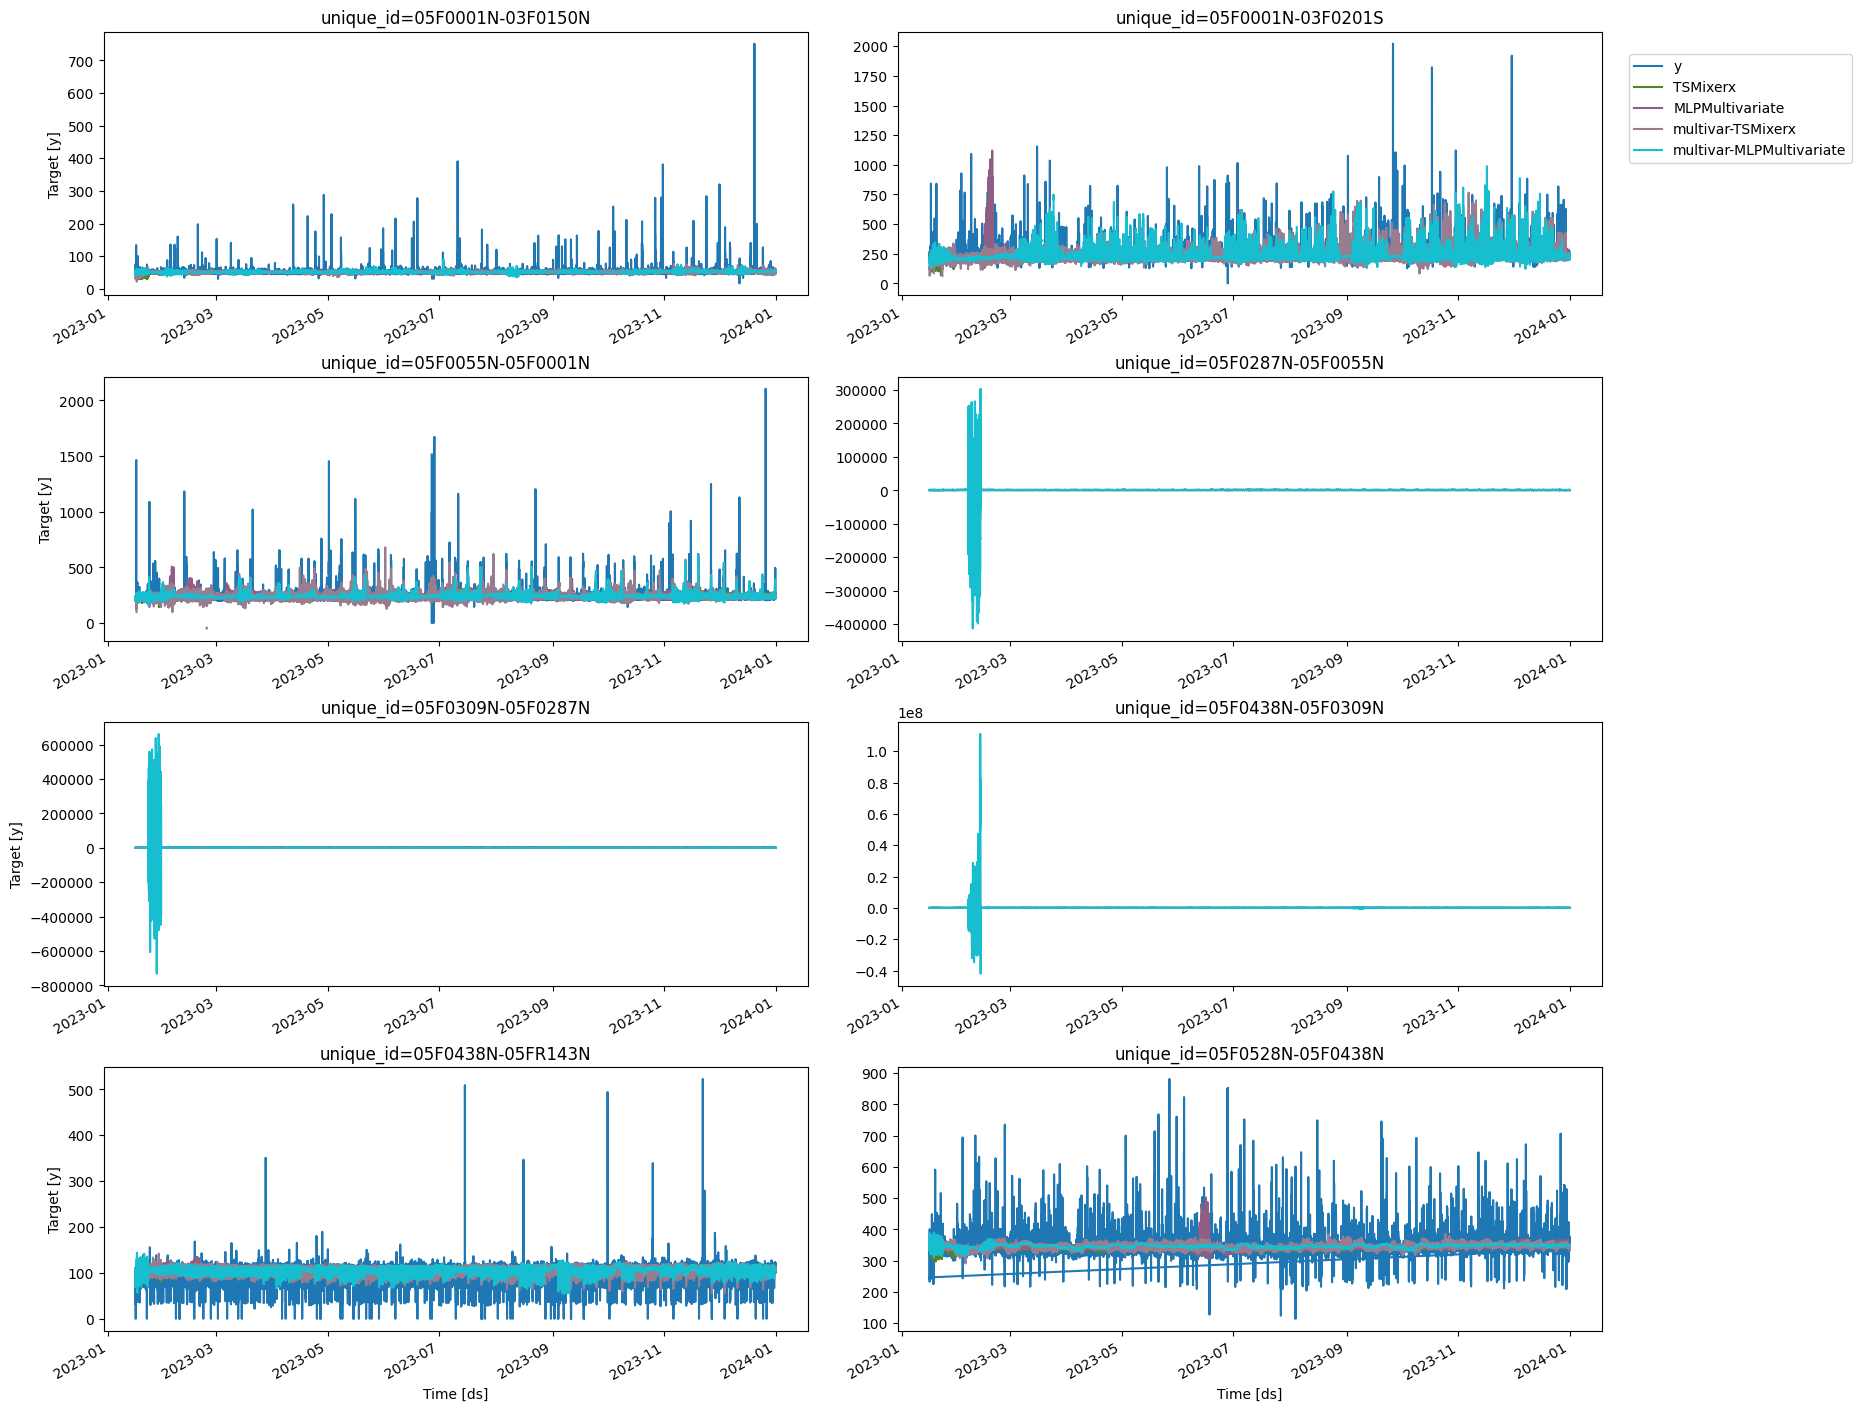

In [96]:
plot_series(all_cv_df, all_cv_df.loc[:, all_cv_df.columns != 'cutoff'], max_insample_length=300)

MLPMultivariate 多變量的版本影響視覺化太嚴重了。  
我們把他排除再看一次

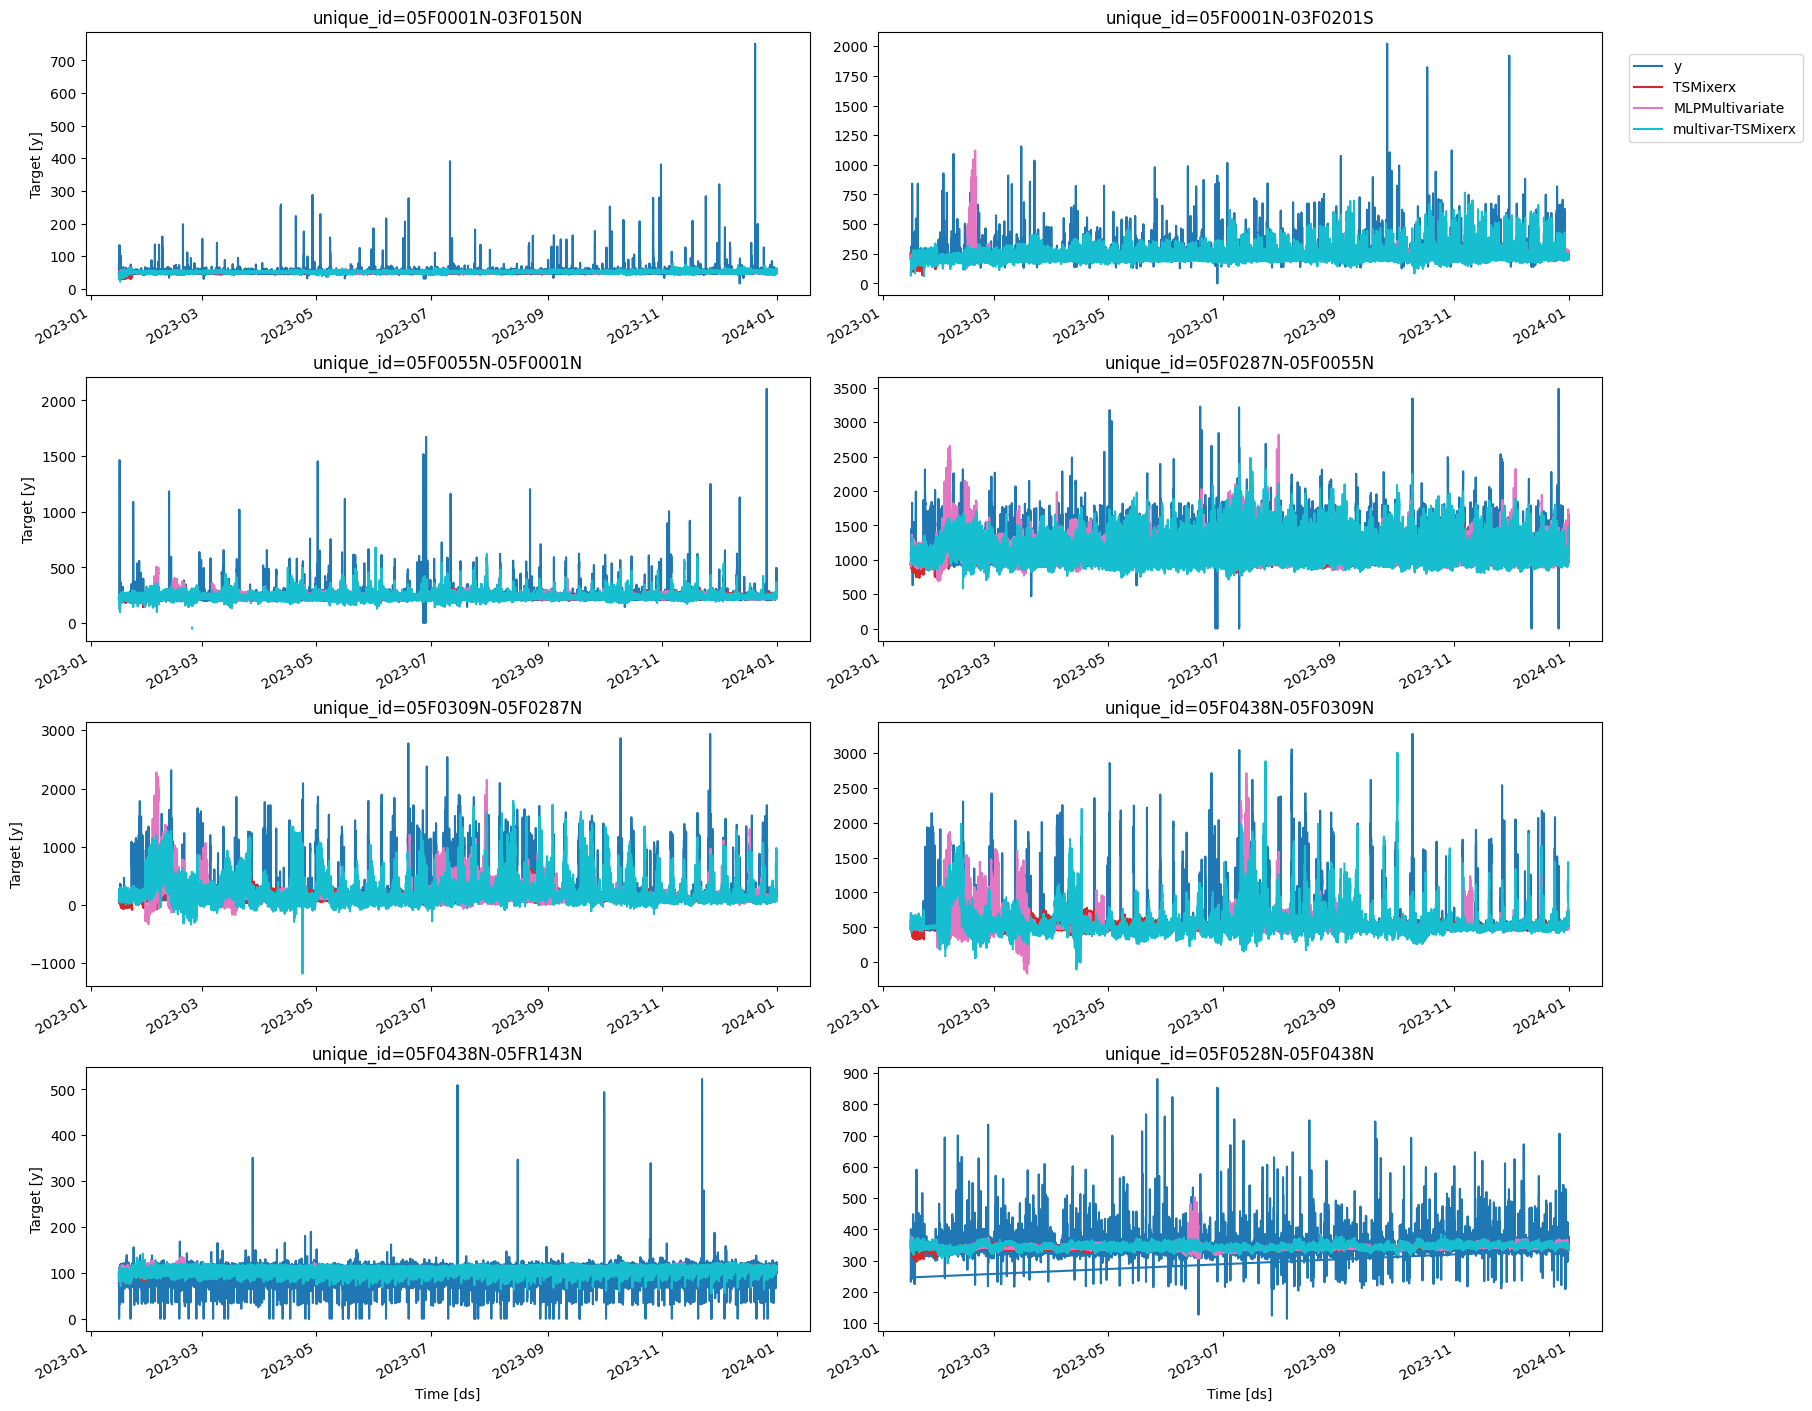

In [99]:
# drop multivar-MLPMultivariate
ta_cols = ['unique_id', 'ds', 'cutoff', 'y', 'TSMixerx', 'MLPMultivariate', 'multivar-TSMixerx']
df = all_cv_df[ta_cols].copy()

plot_series(df, df.loc[:, df.columns != 'cutoff'], max_insample_length=300)

最明顯的部分可以透過與前一次視覺化成果進行比較  
只要看過TSMixerx在加入多變量的下會發現預測上的震盪更大了  
更有機會cover實際旅行時間的部分。  